# HOMEWORK 05

**Submitted by: Diego Sol**

CSCE 636-600: Deep Learning

Professor: Dr. Anxiao Jiang

## Task 1

**Check out the Jupyter notebook for Chapter 8 at https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter08_intro-to-dl-for-computer-vision.ipynb. It uses the convolutional base of VGG16 for an image classification task, and also tries fine tuning. Your task: use another existing trained neural network (which is different from VGG16, such as ResNet) for the same task, and also try fine tuning. Submit your complete code, draw figures on the training/validation performance, and show the testing performance.**

### Initialization and data processing

Upload `kaggle.json` file

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"diegosol","key":"f60bcb6235ead4cd779aa85e779457cc"}'}

Create directory and download data

In [2]:
# create a Kaggle folder
!mkdir ~/.kaggle
# copy the key file to the folder
!cp kaggle.json ~/.kaggle/
# make file readable only by the user
!chmod 600 ~/.kaggle/kaggle.json

# download the data
!kaggle competitions download -c dogs-vs-cats

# unzip data
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

100% 810M/812M [00:13<00:00, 66.3MB/s]
100% 812M/812M [00:13<00:00, 62.3MB/s]


Copy images to training, validation, and test directories

In [3]:
import os, shutil, pathlib

# directory of original uncompressed data
original_dir = pathlib.Path("train")
# directory where we will store the smaller dataset
new_base_dir = pathlib.Path("cats_vs_dogs_small")

# function that copies indexed images of cats and dogs to subdirectories
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

# training subset
make_subset("train", start_index=0, end_index=1000)
# validation subset
make_subset("validation", start_index=1000, end_index=1500)
# test subset
make_subset("test", start_index=1500, end_index=2500)

Read images

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

# training data
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

# validation data
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

# test data
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### Feature extraction without data augmentation

Instante the ResNet50V2 convolutional base

In [5]:
from tensorflow import keras

conv_base = keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(180, 180, 3),
    pooling="avg",
)

94683136/94668760 [==============================] - 1s 0us/step


Extract the ResNet50V2 features and corresponding labels

In [6]:
import numpy as np

# function that extracts features and labels
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.resnet_v2.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

# training features and layers
train_features, train_labels =  get_features_and_labels(train_dataset)
# validation features and layers
val_features, val_labels =  get_features_and_labels(validation_dataset)
# test features and layers
test_features, test_labels =  get_features_and_labels(test_dataset)

Define the network architecture and train the model

In [7]:
from tensorflow.keras import layers

# model architecture
inputs = keras.Input(shape=(2048)) 
x = layers.Dense(256)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

# configure the model for training
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# set callbacks to save the best model and monitor validation loss
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]

# train the model
history = model.fit(
    train_features, train_labels,
    epochs=50,
    validation_data=(val_features, val_labels),
    callbacks=callbacks,
    verbose=0)

print('Training completed.')

Training completed.


Extract accuracy and loss

In [8]:
import matplotlib.pyplot as plt

# accuracy
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

# loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# epochs (x-axis)
epochs = range(1, len(acc) + 1)

Plot accuracy

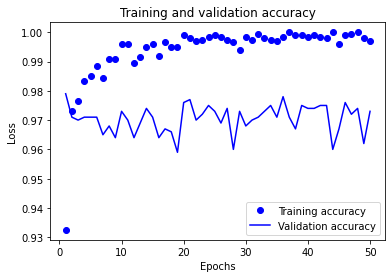

In [9]:
# create figure for accuracy
fig1, ax1 = plt.subplots()

ax1.plot(epochs, acc, "bo", label="Training accuracy")
ax1.plot(epochs, val_acc, "b", label="Validation accuracy")
ax1.set_title("Training and validation accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
plt.show()

Plot loss

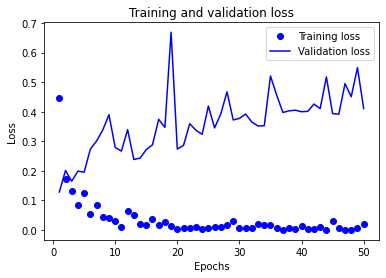

In [10]:
# create figure for accuracy
fig2, ax2 = plt.subplots()

ax2.plot(epochs, loss, "bo", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.set_title("Training and validation loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()
plt.show()

Evaluate the model on the test set

In [11]:
test_model = keras.models.load_model(
    "feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features,test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 2ms/step - loss: 0.1153 - accuracy: 0.9755
Test accuracy: 0.975


### Feature extraction with data augmentation

Instante the ResNet50V2 convolutional base without trainable weights

In [12]:
conv_base = keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    pooling="avg",
)
conv_base.trainable = False

Extract the ResNet50V2 features and corresponding labels

In [13]:
# function that extracts features and labels
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.resnet_v2.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

# training features and layers
train_features, train_labels =  get_features_and_labels(train_dataset)
# validation features and layers
val_features, val_labels =  get_features_and_labels(validation_dataset)
# test features and layers
test_features, test_labels =  get_features_and_labels(test_dataset)

Create data augmentation layer

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Define the network architecture and train the model

In [19]:
# model architecture
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet_v2.preprocess_input(x)
x = conv_base(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

# configure the model for training
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# set callbacks to save the best model and monitor validation loss
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

# train the model
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=0)

print('Training completed.')


Training completed.


Extract accuracy and loss

In [20]:
# accuracy
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

# loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# epochs (x-axis)
epochs = range(1, len(acc) + 1)

Plot accuracy

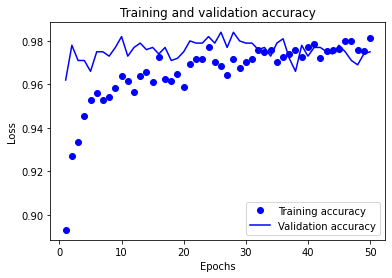

In [21]:
# create figure for accuracy
fig3, ax4 = plt.subplots()

ax4.plot(epochs, acc, "bo", label="Training accuracy")
ax4.plot(epochs, val_acc, "b", label="Validation accuracy")
ax4.set_title("Training and validation accuracy")
ax4.set_xlabel("Epochs")
ax4.set_ylabel("Loss")
ax4.legend()
plt.show()

Plot loss

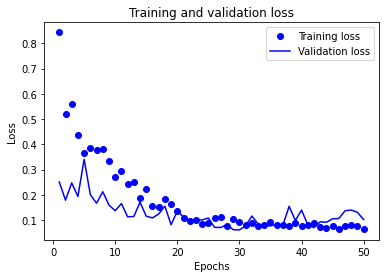

In [22]:
# create figure for accuracy
fig4, ax4 = plt.subplots()

ax4.plot(epochs, loss, "bo", label="Training loss")
ax4.plot(epochs, val_loss, "b", label="Validation loss")
ax4.set_title("Training and validation loss")
ax4.set_xlabel("Epochs")
ax4.set_ylabel("Loss")
ax4.legend()
plt.show()

Evaluate the model on the test set

In [23]:
test_model = keras.models.load_model(
    "feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features,test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 2ms/step - loss: 0.1634 - accuracy: 0.9765
Test accuracy: 0.976
